# IS-4100: NFL Team Performance Analysis using Generalized Linear Models (GLMs)

**Why are GLMs Useful?**
- Flexibility in Modeling Different Types of Data:
  - GLMs can handle various types of response variables:
    - Continuous (Normal distribution)
    - Binary outcomes (Binomial distribution)
    - Counts (Poisson or Negative Binomial distribution)
    - Proportions and more
  - This flexibility allows for modeling data that do not meet the assumptions of traditional linear regression (e.g., non-constant variance, non-normal errors).
- Appropriate for Non-Normal Distributions:
  - Many real-world datasets have response variables that are skewed, bounded, or discrete.
  - GLMs can model these variables appropriately, providing better estimates and inference.
- Interpretability:
  - Coefficients in GLMs can often be interpreted in terms of odds ratios, risk ratios, or rate ratios, which are meaningful in many applied contexts.
- Extensibility:
  - GLMs form the foundation for more advanced models like Generalized Linear Mixed Models (GLMMs), allowing for random effects and hierarchical data structures.
- Modeling Non-Linear Relationships:
  - Through the use of link functions, GLMs can model non-linear relationships between the predictors and the response variable.

In this lab, you will analyze NFL team performance data using Generalized Linear Models (GLMs). You'll utilize the `nfl_data_py` or `nflfastR` to perform your analysis.

**Learning Objectives**
- Data Retrieval: Learn how to fetch and manipulate NFL data using `nfl_data_py` or `nflfastR`.
- Data Preprocessing: Clean and prepare the dataset for modeling.
- GLM Modeling: Understand and apply GLMs to model NFL team performance.
- Interpretation: Interpret the results of your GLM and derive meaningful insights.

**Assignment Overview**

You will perform the following tasks:

- Setup and Data Retrieval
- Data Preprocessing / EDA
  - Build upon feedback and extra functions / methods we have covered in class.
- GLM Modeling
  - Choose an appropriate GLM for modeling team performance.
  - Fit the model and check for assumptions.
- Results Interpretation
  - Analyze the output of your GLM.
  - Discuss the implications of your findings.
- Reporting
  - Summarize your methodology, results, and conclusions in a brief report.

**Extra Resources**
- [nfl_data_py Documentation](https://pypi.org/project/nfl-data-py/)
- [nflfastR Documentation](https://www.nflfastr.com/)
- [nflfastR Data Dictionary](https://www.nflfastr.com/articles/field_descriptions.html)
- [Generalized Linear Models in Python: A Comprehensive Guide](https://statisticseasily.com/generalized-linear-models-in-python/#google_vignette)
- [GLM guide in R](https://albert-rapp.de/posts/14_glms/14_glms)

**Potential Areas to Explore**
- Predicting Touchdown Probability
  - Estimate the probability of a play resulting in a touchdown based on game and play characteristics.
  - Model: Logistic Regression.
- Estimating Player Performance with Poisson Regression
  - Predict the number of tackles a defensive player makes in a game (count data).
- Assessing Penalty Likelihood
  - Predict the probability of a penalty occurring on a play.
  - Model: Logistic Regression
- Evaluating Defensive Sack Rates
  - Analyze factors that contribute to the likelihood of a quarterback sack.
  - Model: Logistic Regression.
- Modeling Over/Under Betting Outcomes
  - Objective: Predict if the total game score will be over or under the bookmaker's line.
  - Model: Logistic Regression.

## Data Retrieval

In [ ]:
install.packages("nflfastR")
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(nflfastR)
library(tidyverse)

In [ ]:
seasons <- c(2016:2023)
pbp <- load_pbp(seasons)

## Data Preprocessing and EDA

In [ ]:
# Filter out null values in the firstdown variable
pbp <- pbp |>
  filter(!is.na(first_down) & play_type == 'run' | play_type == 'pass') |>
  mutate(home_team_ball = ifelse(posteam == home_team, 1, 0))


In [ ]:
cat('Number of First Downs Converted:', nrow(pbp[pbp$first_down == 1,]), '\n',
    'Number of First Downs Not Converted:', nrow(pbp[pbp$first_down == 0,]), '\n',
    'Ratio of Plays that result in First Down:',
    round(nrow(pbp[pbp$first_down == 1,]) / nrow(pbp), 2))

Number of First Downs Converted: 81612 
 Number of First Downs Not Converted: 193518 
 Ratio of Plays that result in First Down: 0.3

Warning message:
“Removed 995 rows containing non-finite outside the scale range
(`stat_count()`).”


Down,Completion_Rate
<dbl>,<dbl>
1,0.213
2,0.333
3,0.403
4,0.522


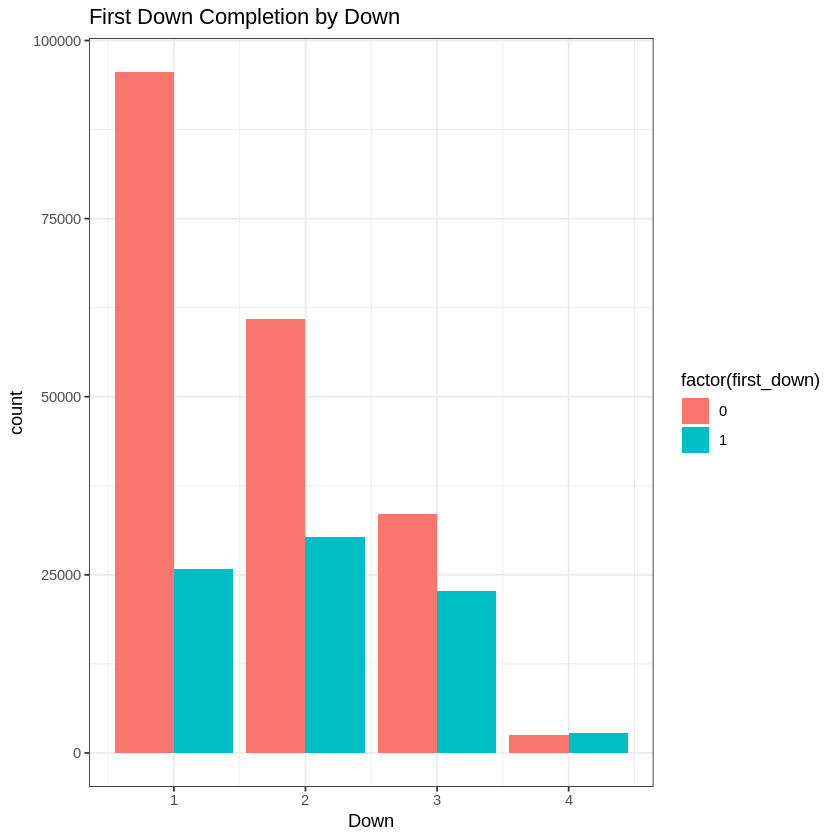

In [ ]:
pbp |> ggplot(aes(x = down, fill = factor(first_down))) +
  geom_bar(position = 'dodge') +
  theme_bw() +
  xlab('Down')+
  labs(title = 'First Down Completion by Down')


Completion_Rates <- pbp |>
  group_by(down) |>
  summarise(First_Down_Completion_Rate = mean(first_down)) |>
  pull(First_Down_Completion_Rate)

Completion_Rates <- Completion_Rates[-5]

data.frame(Down = c(1,2,3,4), Completion_Rate = round(Completion_Rates, 3))

As we observe, a the higher percent of first downs are converted on fourth down than any other down. The frequency of completeing a first down increases as the down number increases.

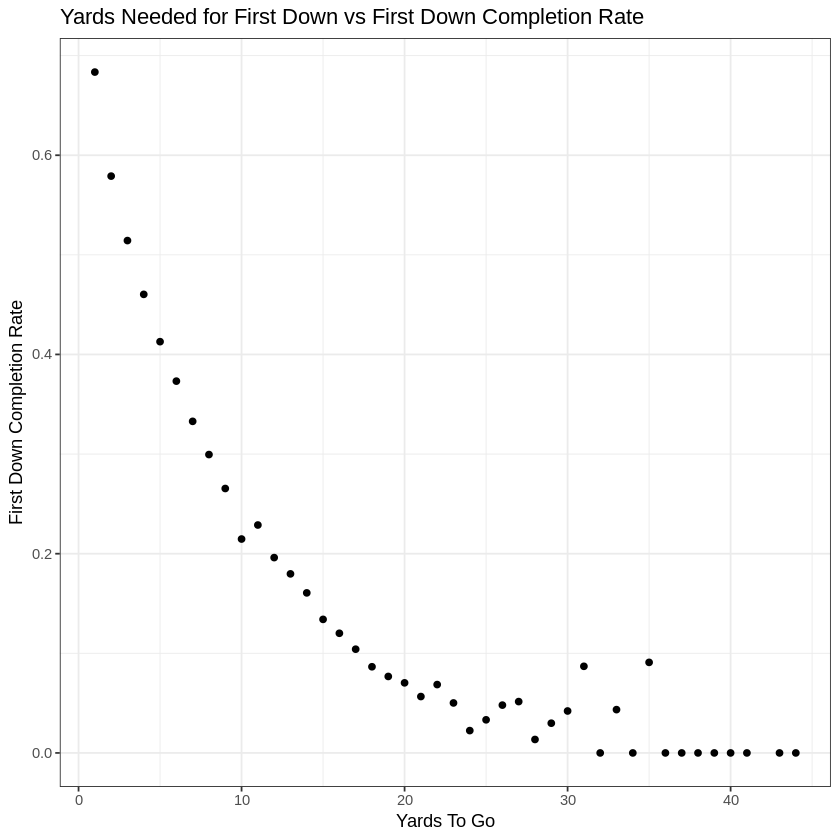

In [ ]:
pbp |>
  filter(ydstogo != 0) |>
  group_by(ydstogo) |>
  summarise(
    First_Down_Completion_Rate = mean(first_down)
  ) |>
  ggplot(aes(x = ydstogo, y = First_Down_Completion_Rate)) +
    geom_point() +
    theme_bw() +
    labs(title = 'Yards Needed for First Down vs First Down Completion Rate') +
    xlab('Yards To Go')+
    ylab('First Down Completion Rate')


As expected, as more yards are needed to gain a first down, the conversion rate of gaining a first down decreases.

Play_Type,Completion_Rate
<chr>,<dbl>
Pass,0.327
Run,0.253


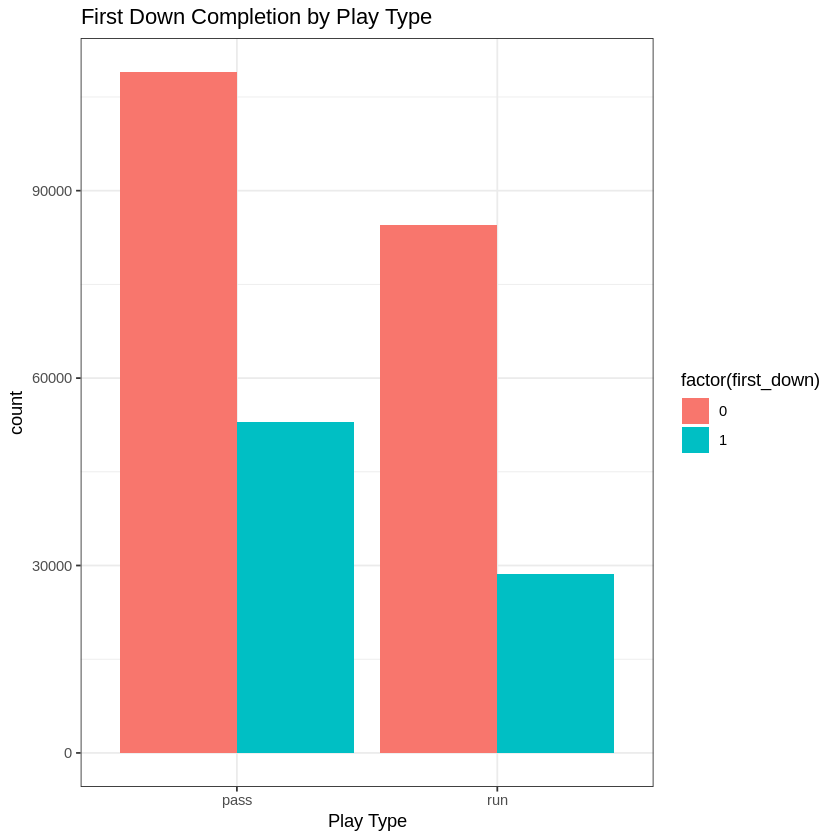

In [ ]:
pbp |>
  filter(play_type == 'run' | play_type == 'pass') |>
  ggplot(aes(x = play_type, fill = factor(first_down))) +
    geom_bar(position = 'dodge') +
    theme_bw() +
    xlab('Play Type')+
    labs(title = 'First Down Completion by Play Type')

Completion_Rates <- pbp |>
  group_by(play_type) |>
  summarise(First_Down_Completion_Rate = mean(first_down)) |>
  pull(First_Down_Completion_Rate)

data.frame(Play_Type = c('Pass', 'Run'), Completion_Rate = round(Completion_Rates, 3))

Pass plays result in first downs more often than run plays. The difference between the success rate is about 7%.

Quarter,Completion_Rate
<chr>,<dbl>
1,0.294
2,0.305
3,0.295
4,0.292
OT,0.282


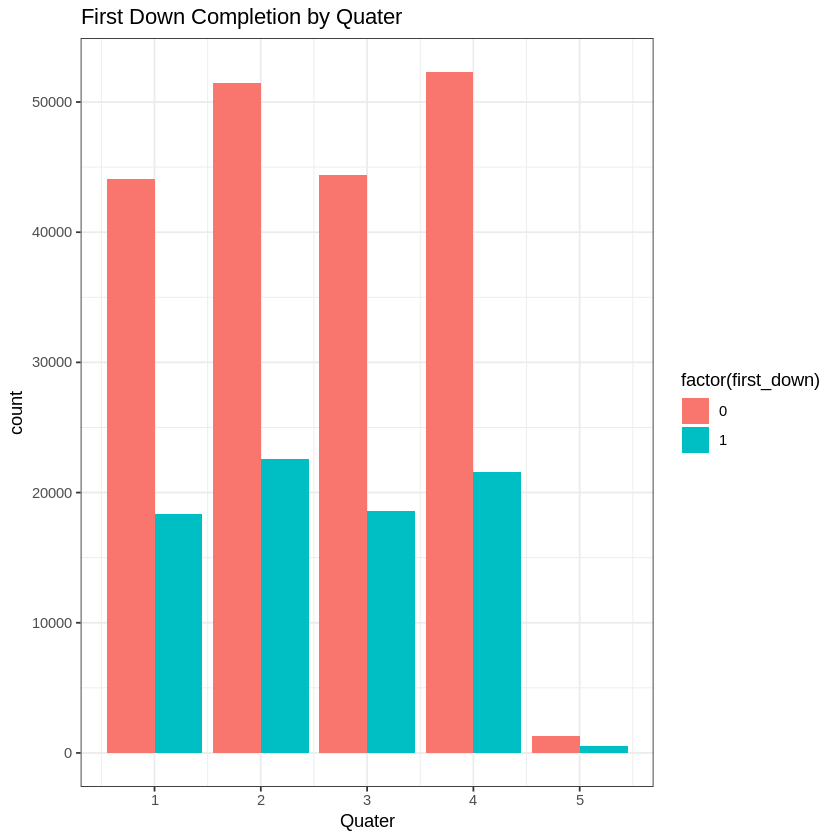

In [ ]:
pbp |>
  ggplot(aes(x = qtr, fill = factor(first_down))) +
    geom_bar(position = 'dodge') +
    theme_bw() +
    xlab('Quater')+
    labs(title = 'First Down Completion by Quater')

Completion_Rates <- pbp |>
  group_by(qtr) |>
  summarise(First_Down_Completion_Rate = mean(first_down)) |>
  pull(First_Down_Completion_Rate)

data.frame(Quarter = c('1', '2', '3', '4', 'OT'), Completion_Rate = round(Completion_Rates, 3))

Quarter does not seem to have an effect on wether or not a play results in a first down. In all quarters, there is about a 30% chance a play will result in a first down.

## Modeling

In [ ]:
# Train and Test Split
set.seed(707)
sampleIdx <- sample(1:nrow(pbp), nrow(pbp)*.7)
train <- pbp[sampleIdx,]
test <- pbp[-sampleIdx,]

In [ ]:
model1 <- glm(
  first_down ~ 1 + ydstogo,
  data = train,
  family = 'binomial'
)

summary(model1)


Call:
glm(formula = first_down ~ 1 + ydstogo, family = "binomial", 
    data = train)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.599572   0.012472   48.07   <2e-16 ***
ydstogo     -0.183265   0.001491 -122.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 234130  on 192590  degrees of freedom
Residual deviance: 216860  on 192589  degrees of freedom
AIC: 216864

Number of Fisher Scoring iterations: 4


In [ ]:
# Next Model iteration
model2 <- glm(
  first_down ~ 1 + ydstogo + down,
  data = train,
  family = 'binomial'
)

summary(model2)


Call:
glm(formula = first_down ~ 1 + ydstogo + down, family = "binomial", 
    data = train)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.183464   0.022884    8.017 1.08e-15 ***
ydstogo     -0.170694   0.001672 -102.085  < 2e-16 ***
down         0.177045   0.007061   25.075  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 233657  on 191919  degrees of freedom
Residual deviance: 214819  on 191917  degrees of freedom
  (671 observations deleted due to missingness)
AIC: 214825

Number of Fisher Scoring iterations: 4


In [ ]:
model3 <- glm(
  first_down ~ 1 + ydstogo + down + down:ydstogo + qtr + home_team_ball + play_type,
  data = train,
  family = 'binomial'
)

summary(model3)


Call:
glm(formula = first_down ~ 1 + ydstogo + down + down:ydstogo + 
    qtr + home_team_ball + play_type, family = "binomial", data = train)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.676135   0.046320  14.597  < 2e-16 ***
ydstogo        -0.183605   0.004678 -39.246  < 2e-16 ***
down            0.109220   0.016966   6.438 1.21e-10 ***
qtr            -0.013185   0.004685  -2.814  0.00489 ** 
home_team_ball  0.048094   0.010585   4.544 5.53e-06 ***
play_typerun   -0.543964   0.011488 -47.349  < 2e-16 ***
ydstogo:down   -0.003243   0.001957  -1.657  0.09751 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 233657  on 191919  degrees of freedom
Residual deviance: 212501  on 191913  degrees of freedom
  (671 observations deleted due to missingness)
AIC: 212515

Number of Fisher Scoring iterations: 4


In [ ]:
model4 <- glm(
  first_down ~ 1 + ydstogo + down + play_type + home_team_ball + qtr,
  data = train,
  family = 'binomial'
)

summary(model4)


Call:
glm(formula = first_down ~ 1 + ydstogo + down + play_type + home_team_ball + 
    qtr, family = "binomial", data = train)

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     0.736184   0.028884   25.487  < 2e-16 ***
ydstogo        -0.190790   0.001767 -107.954  < 2e-16 ***
down            0.083899   0.007377   11.372  < 2e-16 ***
play_typerun   -0.543280   0.011482  -47.317  < 2e-16 ***
home_team_ball  0.048055   0.010584    4.540 5.62e-06 ***
qtr            -0.013173   0.004685   -2.812  0.00493 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 233657  on 191919  degrees of freedom
Residual deviance: 212503  on 191914  degrees of freedom
  (671 observations deleted due to missingness)
AIC: 212515

Number of Fisher Scoring iterations: 4


In [ ]:
test <- test |>
  mutate(first_down_prediction = predict(model4, test),
         classified_predictions = ifelse(first_down_prediction > .5, 1 ,0))


## Results Interpretation

In [ ]:
install.packages('caret')
install.packages('pROC')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(caret)
library(pROC)

In [ ]:
cm <- confusionMatrix(factor(test$first_down), factor(test$classified_predictions))
cm

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 56562  1138
         1 23023  1492
                                         
               Accuracy : 0.7061         
                 95% CI : (0.703, 0.7092)
    No Information Rate : 0.968          
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0553         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.71071        
            Specificity : 0.56730        
         Pos Pred Value : 0.98028        
         Neg Pred Value : 0.06086        
             Prevalence : 0.96801        
         Detection Rate : 0.68798        
   Detection Prevalence : 0.70182        
      Balanced Accuracy : 0.63901        
                                         
       'Positive' Class : 0              
                                      

From the confusion matrix and abismally low precision and recall values, we can see that the model is over predicting not getting a first down. The high accuracy is misleading.

In [ ]:
summary(model4)


Call:
glm(formula = first_down ~ 1 + ydstogo + down + play_type + home_team_ball + 
    qtr, family = "binomial", data = train)

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     0.736184   0.028884   25.487  < 2e-16 ***
ydstogo        -0.190790   0.001767 -107.954  < 2e-16 ***
down            0.083899   0.007377   11.372  < 2e-16 ***
play_typerun   -0.543280   0.011482  -47.317  < 2e-16 ***
home_team_ball  0.048055   0.010584    4.540 5.62e-06 ***
qtr            -0.013173   0.004685   -2.812  0.00493 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 233657  on 191919  degrees of freedom
Residual deviance: 212503  on 191914  degrees of freedom
  (671 observations deleted due to missingness)
AIC: 212515

Number of Fisher Scoring iterations: 4


In [ ]:
varImp(model4)

,Overall
,<dbl>
ydstogo,107.954158
down,11.372299
play_typerun,47.316867
home_team_ball,4.540163
qtr,2.811662


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



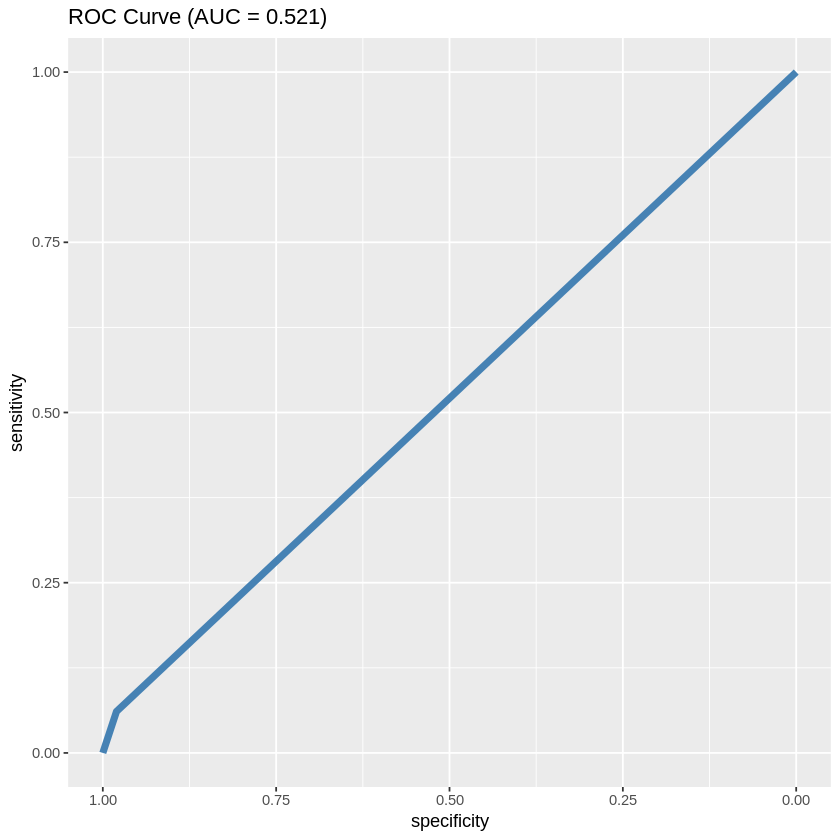

In [ ]:
ROC = roc(test$first_down, test$classified_predictions)
AUC <- round(auc(test$first_down, test$classified_predictions),3)

ggroc(ROC, colour = 'steelblue', size = 2) +
  ggtitle(paste0('ROC Curve ', '(AUC = ', AUC, ')'))

### **Effect on Log Odds**

* Yards to Go: An increase in yards needed to gain a first down decrease the log odds by 0.19.

* Down: An increase in down increase the log odds by 0.08.

* Running Play: A running play decrease the log odds by 0.54.

* Home Team: Being the home team increase the log odds by 0.05.

* Quarter: An increase in quater decrease the log odds by 0.01.


### **Predictor Importance**

The predictors from most important to least important are yards to go, down, play type, home or away team, and quarter.

### **ROC and AUC**
An AUC value of nearly 0.5 is concerning because it means that the model is barley doing better than random guessing. The ROC curve is almost a straight line signifying there is a significant trade off between specificity and sensitivity.

## Reporting

### **Methodology**

<p align = "justify"> I started by loading all play-by-play data from the 2016 NFL season to the 2023 season. Since I was interested in predicting the likelihood of a play resulting in a first down, I filter out all records where the first down binary field was null. Then, I filter the data to only keep plays where the play type was a run or a pass. I did this because other plays types such as punt or field goals will never end in first down, so there is no need to investigate these plays or add them to the model. I then split the pbp dataset into training and testing data sets using a 70-30 split. I then trained different variations of a logistic regression model trying to find the model with the lowest AIC while having all significant predictors. The final model landed on used down, yards needed for a first down, play type, and whether the team was home or away as predictors. </p>

###**Results**
<p align = "justify">
With an embalanced dataset, my model over predicts not completing a first down. An accuracy of around .70 is normally pretty good for a classification model, but when recall and precision are taken into consideration, we see that this model achieves this accuracy by overpredicting no first down completed. The model made 23,023 false negative predictions out of 82,215.
</p>

###**Conclusion**
<p align = "justify">
I would not consider this model good despite of its relatively good accuracy. If I were to make any changes to the process I would consider balancing the training dataset by doing resampling. Only about 30% of all plays result in a first down, so the model was trained on data that had more records where a first down wasn't achieved. I believe this is part of the reason the model failed to be useful.
</p>